# <font  color = "#0093AF">Overhauser Effect</font>

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter4/Ch4_OverhauserEffect.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

The Overhauser effect is the original DNP experiment,$^1$ demonstrated on a conducting metal.$^2$ However, it is also possible to obtain the Overhauser effect from non-conducting electrons such as in trityl or BDPA. In this case, the effect comes from either modulation of the isotropic or dipolar part of the hyperfine coupling. Here, we introduce these modulations, and see the effect they have on the transfer of polarization between the electron and the nucleus.

[1] A.W. Overhauser. [*Phys. Rev.*](https://doi.org/10.1103/PhysRev.92.411), **1953**, 92, 411-415

[2] T.R. Carver, C.P. Slichter. [*Phys. Rev.*](https://doi.org/10.1103/PhysRev.92.212.2), **1953**, 92, 212-213.

## Setup

In [0]:
# SETUP SLEEPY
import sys
if 'google.colab' in sys.modules:
  !pip install sleepy-nmr

In [2]:
import SLEEPY as sl
LFrf=sl.LFrf
import numpy as np
import matplotlib.pyplot as plt

## Example 1: Modulation of the Isotropic Hyperfine (J)

In the first example, we include a scalar and dipolar component to the coupling. However, we only modulate the scalar part. This is achieved by adding different scalar couplings to `ex0` and `ex1` (`Aiso`,`Aiso1`). The two Hamiltonians are then coupled together with the exchange matrix produced by `sl.Tools.twoSite_kex(tc=...)`, where `tc` specifies the correlation time resulting from the exchange matrix.

Increasing the change between `Aiso` and `Aiso1` will accelerate the transfer. Modifying `tc` will also change the rate, although the current value (1 ps) is nearly optimum for fast transfer.

Note that for the Overhauser effect, we require the full set of non-secular interactions in the lab frame, not just the pseudo-secular terms tilting the nucleus that are required for cross-effect and solid-effect. Therefore, all spins are calculated in the lab frame.

### Build the system

In [3]:
ex0=sl.ExpSys(v0H=212,Nucs=['1H','e'],LF=True,vr=5000,n_gamma=30)
ex0.set_inter('g',i=1,gxx=2.0027,gyy=2.0031,gzz=2.0034)
Adip=[-1e6,-1e6,2e6]
Aiso0=.75e6
ex0.set_inter('hyperfine',i0=0,i1=1,Axx=Adip[0]+Aiso0,Ayy=Adip[1]+Aiso0,Azz=Adip[2]+Aiso0)
ex1=ex0.copy()
Aiso1=.25e6
ex1.set_inter('hyperfine',i0=0,i1=1,Axx=Adip[0]+Aiso1,Ayy=Adip[1]+Aiso1,Azz=Adip[2]+Aiso1)

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=1e-12)

### Propagate and plot

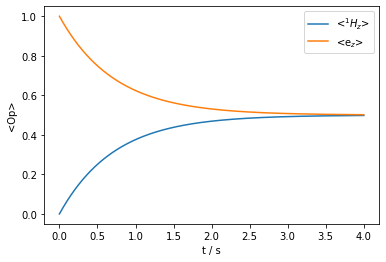

In [4]:
seq=L.Sequence()
rho=sl.Rho('ez',['1Hz','ez'])
rho.DetProp(seq,n=20000)
_=rho.plot(axis='s')

We observe that the relaxation is a pure transfer from modulation of the isotropic part of the hyperfine coupling. No magnetization is lost.

## Example 2: Reorientation of the Dipolar Hyperfine
In the second example, we leave the isotropic component fixed, and reorient the dipolar component of the hyperfine coupling.

### Edit the interactions

In [5]:
ex1.set_inter('hyperfine',i0=0,i1=1,
              Axx=Adip[0]+Aiso0,Ayy=Adip[1]+Aiso0,Azz=Adip[2]+Aiso0,
              euler=[0,np.pi/4,0])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=1e-12)

### Propagate and plot

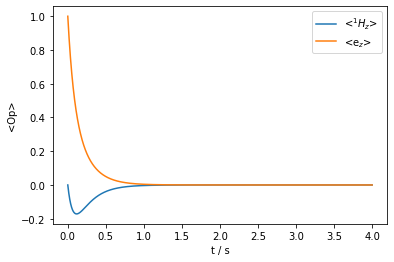

In [6]:
seq=L.Sequence()
rho=sl.Rho('ez',['1Hz','ez'])
rho.DetProp(seq,n=20000)
_=rho.plot(axis='s')

We see sharp contrasts between the two Overhauser effect mechanisms. When the scalar coupling is modulated, the total magnetization is conserved: it is simply transferred between the electron and nucleus until the magnetization is equilibrated. On the other hand, reorientation of the dipolar component both transfers magnetization between electron and nucleus, but also gradually destroys the total magnetization. We also notice that the sign of the transfer changes. We can simulate both mechanisms simultaneously (we reduce the size of the dipolar modulation to make the two effects occur on a similar timescale).

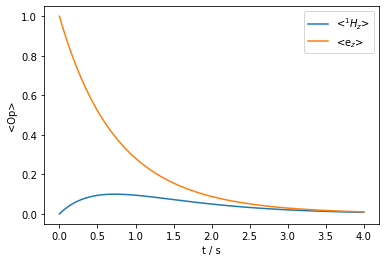

In [7]:
ex1.set_inter('hyperfine',i0=0,i1=1,
              Axx=Adip[0]+Aiso1,Ayy=Adip[1]+Aiso1,Azz=Adip[2]+Aiso1,
              euler=[0,np.pi/16,0])
L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=1e-12)

seq=L.Sequence()
rho=sl.Rho('ez',['1Hz','ez'])
rho.DetProp(seq,n=20000)
_=rho.plot(axis='s')

Then, the sign of the transfer turns positive, indicating the scalar mechanism, but the dipolar mechanism is also present and gradually destroys the magnetization. Note that in the real experiment, we would have a *much* faster electron relaxation, which would effectively decouple it from the $^1$H relaxation, and provide a constant source of polarization to transfer to many $^1$H. However, if the electron is saturated, then during its recovery, the $^1$H would become polarized. We demonstrate this effect next.

## Example 3: Overhauser Effect buildup with Saturating field

This last calculation requires a few special features of SLEEPY, because the Overhauser effect only occurs in the lab frame, so we must also irradiate the electron in the lab frame. It also requires recovery to thermal equilibrium, which is implemented differently under dynamic conditions than if using explicit $T_1$ (i.e. here we use a non-Lindblad implementation).

Some caution should be taken with the 'DynamicThermal' method (see [$T_1$ tests](../Chapter2/Ch2_T1_limits.ipynb)). We check here first that thermal equilibrium is obtained correctly for this system, before we apply microwave irradiation to the electron.

### Build the system

In [8]:
ex0=sl.ExpSys(v0H=212,Nucs=['1H','e'],LF=True,vr=5000,n_gamma=30,pwdavg=sl.PowderAvg(q=2)[10],T_K=-80)
ex0.set_inter('g',i=1,gxx=2.0027,gyy=2.0031,gzz=2.0034)
Adip=[-1e6,-1e6,2e6]
Aiso0=.75e6
ex0.set_inter('hyperfine',i0=0,i1=1,Axx=Adip[0]+Aiso0,Ayy=Adip[1]+Aiso0,Azz=Adip[2]+Aiso0)
ex1=ex0.copy()
Aiso1=.25e6
ex1.set_inter('hyperfine',i0=0,i1=1,Axx=Adip[0]+Aiso1,Ayy=Adip[1]+Aiso1,Azz=Adip[2]+Aiso1,euler=[0,np.pi/8,0])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=1e-12)

ex0.pwdavg=sl.PowderAvg(2)[10]
L.add_relax('DynamicThermal')

gavg=(2.0027+2.0031+2.0034)/3
ge=sl.Constants['ge']

### Propagate without microwaves
We start without magnetization in the system and allow it to evolve to thermal equilibrium. We mark the expected thermal polarization of the electron and nucleus with dashed lines on the plot.

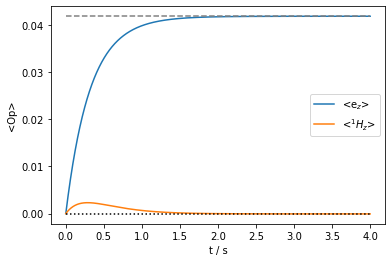

In [9]:
seq=L.Sequence()
rho=sl.Rho('zero',['ez','1Hz'])
rho.DetProp(seq,n=20000)
ax=rho.plot(axis='s')
ax.plot(rho.t_axis[[0,-1]],np.ones(2)*ex0.Peq[0],color='black',linestyle=':')
_=ax.plot(rho.t_axis[[0,-1]],np.ones(2)*ex0.Peq[1],color='grey',linestyle='--')

We get good performance here from the 'DynamicThermal' method. Now we observe the Overhauser effect enhancement by irradiating the electron such that it saturates, leading to enhancement on the $^1$H.

### Lab frame irradiation

In [10]:
# Note that we have to be careful to get the electron on-resonance
seq=L.Sequence().add_channel('e',v1=5e6,voff=ex0.v0[1]*(gavg-ge)/ge)  #5 MHz irradiating field
U=LFrf(seq).U()

LF calculation: |██████████████████████████████| 100% complete
Completed


### Propagate and plot

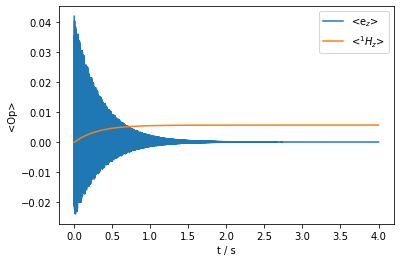

In [11]:
rho=sl.Rho('Thermal',['ez','1Hz'])
# This extracts the final polarization
# normalize to thermal polarization
e=(U**np.inf*rho)().I[1,0].real/ex0.Peq[0]

# Clear, run the buildup
rho.clear()
rho.DetProp(U,n=20000)
_=rho.plot(axis='s')

In [12]:
print(f'Enhancement: {e:.1f}')

Enhancement: -89.3


As desired, saturating the electron results in enhanced polarization on the nucleus.

Now, we attempt to extract the $^1$H T$_1$ and transfer rate, $\Gamma_{IS}$, and use these rates to predict the enhancement and compare to our result

### Predict enhancement from rate constants
The nuclear enhancement should be given by

$$
\begin{equation}
\frac{P_{DNP}}{P^{1H}_{eq}}=\left(1+\frac{\Gamma_{IS}}{R_1^{1H}}\cdot\frac{P^{e-}_{eq}}{P^{1H}_{eq}}\right)
\end{equation}
$$

We estimate $\Gamma_{IS}$ and $R_1^{1H}$ from their initial slopes in short simulations below to predict the enhancement.

In [13]:
L.clear_relax()

U=L.U()

rho=sl.Rho('1Hz','1Hz')
rho.DetProp(U,n=200)

R1H=(rho.I[0][0]-rho.I[0][1]).real/rho.t_axis[1]

rho=sl.Rho('ez','1Hz')
rho.DetProp(U,n=200)

Gamma=-rho.I[0][1].real/rho.t_axis[1]

print(f'Predicted Enhancement : {1+Gamma/R1H*sl.Tools.NucInfo("e")/sl.Tools.NucInfo("1H"):.1f}')

Predicted Enhancement : -89.5


We confirm that the nuclear enhancement can be predicted from the nuclear $T_1$ (`R1H`) and the electron-nuclear cross relaxation rate (`Gamma`).

### Include powder average
We need to set the powder average, and reintroduce `DynamicThermal`

LF calculation: |██████████████████████████████| 100% complete
Completed


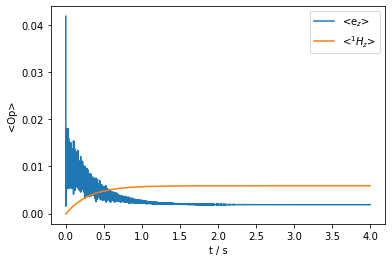

In [14]:
ex0.pwdavg=2
L.add_relax('DynamicThermal')


U=LFrf(seq).U()

rho=sl.Rho('Thermal',['ez','1Hz'])

rho.DetProp(U,n=20000)

_=rho.plot(axis='s')

In [15]:
print(f'Enhancement: {rho.I[1][-1].real/ex0.Peq[0]:.1f}')

Enhancement: -93.0


### Predicted enhancement

In [16]:
L.clear_relax()

U=L.U()

rho=sl.Rho('1Hz','1Hz')
rho.DetProp(U,n=200)

R1H=(rho.I[0][0]-rho.I[0][1]).real/rho.t_axis[1]

rho=sl.Rho('ez','1Hz')
rho.DetProp(U,n=200)

Gamma=-rho.I[0][1].real/rho.t_axis[1]

print(f'Predicted Enhancement : {1+Gamma/R1H*sl.Tools.NucInfo("e")/sl.Tools.NucInfo("1H"):.1f}')

Predicted Enhancement : -92.0


Note that small deviations from the expected enhancement arise from incomplete saturation of the electron.